In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt  # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.10.0+cu111 (Tesla P100-PCIE-16GB)


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="rkDSl2cznyqq6Rb6XNAC")
project = rf.workspace().project("skull-tattoos")
dataset = project.version(1).download("yolov5")

     |████████████████████████████████| 145 kB 7.7 MB/s 
     |████████████████████████████████| 178 kB 56.4 MB/s 
     |████████████████████████████████| 1.1 MB 64.2 MB/s 
     |████████████████████████████████| 67 kB 7.8 MB/s 
     |████████████████████████████████| 138 kB 75.8 MB/s 
     |████████████████████████████████| 62 kB 1.1 MB/s 
  Created wheel for roboflow: filename=roboflow-0.1.8-py3-none-any.whl size=20082 sha256=0000ead5c7d3615090179cf3996233ded591f048707a71beeacaeb3a40f67c8d
  Stored in directory: /root/.cache/pip/wheels/db/11/cc/728f5aaa27dd0a16f49c73090f1ef72ba4701c4c0999eba381
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=6dc2f5b3ce7f8bdd5ed9fd7b7de56d89d79f5c5724e0cae170ffc0bde0f353f5
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built roboflow wget
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:


loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Skull-Tattoos-1 in yolov5pytorch:: 100%|██████████| 1033/1033 [00:00<00:00, 1320.95it/s]


In [4]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [5]:
# define number of classes based on YAML
import yaml

with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [6]:
%%writetemplate {dataset.location}/data.yaml

# train and val data as 1) directory: path/images/, 2) file: path/images.txt, or 3) list: [path1/images/, path2/images/]
train: {dataset.location}/train
val: {dataset.location}/valid

# parameters
nc: {num_classes}  # number of classes
names: [ 'Skull' ]

In [7]:
%cat {dataset.location}/data.yaml


# train and val data as 1) directory: path/images/, 2) file: path/images.txt, or 3) list: [path1/images/, path2/images/]
train: /content/yolov5/Skull-Tattoos-1/train
val: /content/yolov5/Skull-Tattoos-1/valid

# parameters
nc: 1  # number of classes
names: [ 'Skull' ]

In [8]:
#this is the model configuration we will use for our tutorial 
%cat /content/yolov5/models/yolov5m.yaml

# YOLOv5 🚀 by Ultralytics, GPL-3.0 license

# Parameters
nc: 80  # number of classes
depth_multiple: 0.67  # model depth multiple
width_multiple: 0.75  # layer channel multiple
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Conv, [64, 6, 2, 2]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, C3, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 6, C3, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, C3, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 3, C3, [1024]],
   [-1, 1, SPPF, [1024, 5]],  # 9
  ]

# YOLOv5 v6.0 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, C3, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]]

In [9]:
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 8 --epochs 150 --data {dataset.location}/data.yaml --cfg ./models/yolov5m.yaml --weights '' --name yolov5m_results  --cache

/content/yolov5
train: weights=, cfg=./models/yolov5m.yaml, data=/content/yolov5/Skull-Tattoos-1/data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=150, batch_size=8, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=runs/train, name=yolov5m_results, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, patience=100, freeze=0, save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.0-103-g7a39803 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.1, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0,

In [10]:
!python detect.py --weights "/content/yolov5/runs/train/yolov5m_results/weights/best.pt" --img-size 416 --conf 0.1 --source '/content/drive/MyDrive/Skull_Base_Images/skull tumblr aesthetic line art tattoosimg_20.jpg'

detect: weights=['/content/yolov5/runs/train/yolov5m_results/weights/best.pt'], source=/content/drive/MyDrive/Skull_Base_Images/skull tumblr aesthetic line art tattoosimg_20.jpg, imgsz=[416, 416], conf_thres=0.1, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.0-103-g7a39803 torch 1.10.0+cu111 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model Summary: 290 layers, 20852934 parameters, 0 gradients, 47.9 GFLOPs
image 1/1 /content/drive/MyDrive/Skull_Base_Images/skull tumblr aesthetic line art tattoosimg_20.jpg: 416x320 1 Skull, Done. (0.017s)
Speed: 0.5ms pre-process, 17.1ms inference, 1.4ms NMS per image at shape (1, 3, 416, 416)
Results saved to runs/detect/exp


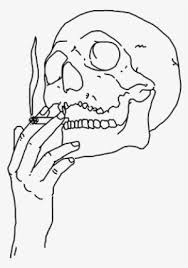

In [11]:
Image(filename='/content/drive/MyDrive/Skull_Base_Images/skull tumblr aesthetic line art tattoosimg_20.jpg', width=600)

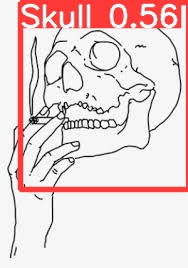

In [12]:
Image(filename='/content/yolov5/runs/detect/exp/skull tumblr aesthetic line art tattoosimg_20.jpg', width=600)

In [19]:
!rm "/content/drive/MyDrive/Skull_Base_Images/skull tattoo artimg_679.jpg"
!rm "/content/drive/MyDrive/Skull_Base_Images/skull tattoo artworkimg_571.jpg"
!rm "/content/drive/MyDrive/Skull_Base_Images/skull tattoo line artimg_498.jpg"
#!rm "/content/drive/MyDrive/Scorpion_Base_Images/scorpion tattoo sketch drawing ideasimg_267.jpg"
!rm -r /content/yolov5/runs/detect/exp2

rm: cannot remove '/content/drive/MyDrive/Skull_Base_Images/skull tattoo artimg_679.jpg': No such file or directory
rm: cannot remove '/content/drive/MyDrive/Skull_Base_Images/skull tattoo artworkimg_571.jpg': No such file or directory


In [20]:
!python detect.py --weights "/content/yolov5/runs/train/yolov5m_results/weights/best.pt" --img-size 416 --conf 0.5 --source /content/drive/MyDrive/Skull_Base_Images/ --save-crop

Streaming output truncated to the last 5000 lines.
image 16047/21044 /content/drive/MyDrive/Skull_Base_Images/tattoodoskull illustration tattooimg_165.jpg: 416x288 1 Skull, Done. (0.016s)
image 16048/21044 /content/drive/MyDrive/Skull_Base_Images/tattoodoskull illustration tattooimg_166.jpg: 416x416 1 Skull, Done. (0.012s)
image 16049/21044 /content/drive/MyDrive/Skull_Base_Images/tattoodoskull illustration tattooimg_167.jpg: 416x416 Done. (0.011s)
image 16050/21044 /content/drive/MyDrive/Skull_Base_Images/tattoodoskull illustration tattooimg_168.jpg: 416x416 1 Skull, Done. (0.012s)
image 16051/21044 /content/drive/MyDrive/Skull_Base_Images/tattoodoskull illustration tattooimg_169.jpg: 416x416 1 Skull, Done. (0.010s)
image 16052/21044 /content/drive/MyDrive/Skull_Base_Images/tattoodoskull illustration tattooimg_17.jpg: 416x320 Done. (0.016s)
image 16053/21044 /content/drive/MyDrive/Skull_Base_Images/tattoodoskull illustration tattooimg_170.jpg: 416x416 Done. (0.012s)
image 16054/21044 

In [21]:
!rm -r /content/drive/MyDrive/GAN_Training_Set/Skull_Tattoo
!rm -r /content/drive/MyDrive/Skull_Training_Set
!mkdir /content/drive/MyDrive/Skull_Training_Set
!mkdir /content/drive/MyDrive/Skull_Training_Set/Tattoo
!mkdir /content/drive/MyDrive/GAN_Training_Set/Skull_Tattoo

In [22]:
!cp -v -r -u /content/yolov5/runs/detect/exp2/crops/Skull/. /content/drive/MyDrive/Skull_Training_Set/Tattoo
!cp -v -r -u /content/yolov5/runs/detect/exp2/crops/Skull/. /content/drive/MyDrive/GAN_Training_Set/Skull_Tattoo

!cp /content/yolov5/runs/train/yolov5m_results/weights/best.pt /content/drive/MyDrive/Skull_Training_Set/best.pt

Streaming output truncated to the last 5000 lines.
'/content/yolov5/runs/detect/exp2/crops/Skull/./skull tattoo sketch drawing ideasimg_713.jpg' -> '/content/drive/MyDrive/GAN_Training_Set/Skull_Tattoo/./skull tattoo sketch drawing ideasimg_713.jpg'
'/content/yolov5/runs/detect/exp2/crops/Skull/./skull tattoo sketch drawing ideasimg_715.jpg' -> '/content/drive/MyDrive/GAN_Training_Set/Skull_Tattoo/./skull tattoo sketch drawing ideasimg_715.jpg'
'/content/yolov5/runs/detect/exp2/crops/Skull/./skull tattoo sketch drawing ideasimg_716.jpg' -> '/content/drive/MyDrive/GAN_Training_Set/Skull_Tattoo/./skull tattoo sketch drawing ideasimg_716.jpg'
'/content/yolov5/runs/detect/exp2/crops/Skull/./skull tattoo sketch drawing ideasimg_717.jpg' -> '/content/drive/MyDrive/GAN_Training_Set/Skull_Tattoo/./skull tattoo sketch drawing ideasimg_717.jpg'
'/content/yolov5/runs/detect/exp2/crops/Skull/./skull tattoo sketch drawing ideasimg_7172.jpg' -> '/content/drive/MyDrive/GAN_Training_Set/Skull_Tattoo/.

In [23]:
import os
print(len([name for name in os.listdir('/content/drive/MyDrive/Skull_Training_Set/Tattoo')]))

18664


In [ ]:
drive.flush_and_unmount()